In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.stats import norm , cauchy
import matplotlib.mlab as mlab
from numpy import mean
from scipy.optimize import curve_fit
import math
from numpy import random
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [29]:
def calc_spin0(theta1,phi1,alpha_1,alpha_psi):
    temp = [0,0,0]
    n1x = np.sin(theta1)*np.cos(phi1)
    n1y = np.sin(theta1)*np.sin(phi1)
    n1z = np.cos(theta1)
    temp[0]=alpha_1*(1-alpha_psi)/(3+alpha_psi)*n1x
    temp[1]=-alpha_1*(1-alpha_psi)/(3+alpha_psi)*n1y
    temp[2]=-alpha_1*(1+3*alpha_psi)/(3+alpha_psi)*n1z
    return temp;

def calc_dir_LAB(Theta,Phi):
    temp = [0,0,0]
    temp[0] = np.sin(Theta)*np.cos(Phi)
    temp[1] = np.sin(Theta)*np.sin(Phi)
    temp[2] = 31.25*(np.cos(Theta)+1)
    norm = np.sqrt(temp[0]**2+temp[1]**2+temp[2]**2)
    temp[0] = temp[0]/norm
    temp[1] = temp[1]/norm
    temp[2] = temp[2]/norm

    return temp;

def calc_t(direction_LAB):
    return 4/(c*0.9994878318624929*direction_LAB[2])

def rotation(alfa, beta, gamma, vector):
    temp = vector
    R1=[[np.cos(alfa),-np.sin(alfa),0],
        [np.sin(alfa), np.cos(alfa), 0],
        [0, 0, 1]] 
    R2=[[np.cos(beta),0,np.sin(beta)],
        [0, 1, 0],
        [-np.sin(beta), 0, np.cos(beta)]]
    R3=[[np.cos(gamma),-np.sin(gamma),0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]]    
    return np.matmul(R1,np.matmul(R2,np.matmul(R3,temp)))

def dot_product_3d(vec1,vec2):
    return vec1[0][0]*vec2[0][0]+vec1[1][0]*vec2[1][0]+vec1[2][0]*vec2[2][0]

def vector_product_3d(vec1, vec2):
    temp = [[vec1[1][0]*vec2[2][0]-vec1[2][0]*vec2[1][0]],
            [-vec1[0][0]*vec2[2][0]+vec1[2][0]*vec2[0][0]],
            [vec1[0][0]*vec2[1][0]-vec1[1][0]*vec2[0][0]]]
    return temp

def calc_ang_vel_precession(direction_LAB, Theta, Phi, g):
    muB_h=4.0261e7;    
    Omega_x = muB_h*(g*(0-0.947*c*direction_LAB[1]*1*direction_LAB[0]));
    Omega_y = muB_h*(g*(1-0.947*c*direction_LAB[1]*1*direction_LAB[1]));
    Omega_z = muB_h*(g*(0-0.947*c*direction_LAB[1]*1*direction_LAB[2]));
    temp = [[Omega_x],[Omega_y],[Omega_z]]
    x = [[1],[0],[0]]
    y = [[0],[1],[0]]
    z = [[0],[0],[1]]
    x = rotation(np.pi+Phi, np.pi-Theta, 0, x)
    y = rotation(np.pi+Phi, np.pi-Theta, 0, y)
    z = rotation(np.pi+Phi, np.pi-Theta, 0, z)
    Omega_x = dot_product_3d(temp,x)
    Omega_y = dot_product_3d(temp,y)
    Omega_z = dot_product_3d(temp,z)
    norm = np.sqrt(Omega_x**2+Omega_y**2+Omega_z**2)
    veloc = [Omega_x/norm,Omega_y/norm, Omega_z/norm]
    return norm, veloc;

def calc_s_precession(Omega, ang_vel, spin0, t):
    spin_temp = [[spin0[0]],[spin0[1]],[spin0[2]]]
    omega_temp = [[ang_vel[0]],[ang_vel[1]],[ang_vel[2]]]
    dot = dot_product_3d(spin_temp,omega_temp)
    cross = vector_product_3d(spin_temp, omega_temp)
    temp = [dot*ang_vel[0]+(spin0[0]-dot*ang_vel[0])*np.cos(Omega*t)+cross[0][0]*np.sin(Omega*t),
            dot*ang_vel[1]+(spin0[1]-dot*ang_vel[1])*np.cos(Omega*t)+cross[1][0]*np.sin(Omega*t),
            dot*ang_vel[2]+(spin0[2]-dot*ang_vel[2])*np.cos(Omega*t)+cross[2][0]*np.sin(Omega*t)]
    return temp   

In [36]:
def decay_distribution_precess(X,g,d): 
    Theta,Phi,theta1,phi1,theta2,phi2=X
    n2x = np.sin(theta2)*np.cos(phi2)
    n2y = np.sin(theta2)*np.sin(phi2)
    n2z = np.cos(theta2)
    spin0 = calc_spin0(theta1,phi1,-0.750,0.461)
    direction_LAB = calc_dir_LAB(Theta,Phi)
    #print(direction_LAB)
    t = 4/(299792458*0.9994878318624929*direction_LAB[2])
    #Omega, ang_vel = calc_ang_vel_precession(direction_LAB, Theta, Phi, g)
    #spin_precess = calc_s_precession(Omega, ang_vel, spin0, t)
    
    muB_h=4.02782*10**7 
    beta = 0.9994878318624929
    Omega_x = muB_h*(g*(0-0.969*beta*direction_LAB[1]*1*direction_LAB[0])-d*beta*direction_LAB[2]);
    Omega_y = muB_h*(g*(1-0.969*beta*direction_LAB[1]*1*direction_LAB[1]));
    Omega_z = muB_h*(g*(0-0.969*beta*direction_LAB[1]*1*direction_LAB[2])+d*beta*direction_LAB[0]);
    temp = [[Omega_x],[Omega_y],[Omega_z]]
    alfa = np.pi+Phi
    beta = np.pi-Theta
    xr = [[np.cos(beta)*np.cos(alfa)],[np.sin(alfa)*np.cos(beta)],[-np.sin(beta)]]
    yr = [[-np.sin(alfa)],[np.cos(alfa)],[0]]
    zr = [[np.sin(beta)*np.cos(alfa)],[np.sin(alfa)*np.sin(beta)],[np.cos(beta)]]
    Omega_xr = dot_product_3d(temp,xr)
    Omega_yr = dot_product_3d(temp,yr)
    Omega_zr = dot_product_3d(temp,zr)
    Omega = np.sqrt(Omega_xr**2+Omega_yr**2+Omega_zr**2)
    ang_vel = [Omega_xr/Omega,Omega_yr/Omega, Omega_zr/Omega]

    spin_temp = [[spin0[0]],[spin0[1]],[spin0[2]]]
    omega_temp = [[ang_vel[0]],[ang_vel[1]],[ang_vel[2]]]
    dot = dot_product_3d(spin_temp,omega_temp)
    cross = vector_product_3d(spin_temp, omega_temp)
    spin_precess = [dot*ang_vel[0]+(spin0[0]-dot*ang_vel[0])*np.cos(Omega*t)+cross[0][0]*np.sin(Omega*t),
                    dot*ang_vel[1]+(spin0[1]-dot*ang_vel[1])*np.cos(Omega*t)+cross[1][0]*np.sin(Omega*t),
                    dot*ang_vel[2]+(spin0[2]-dot*ang_vel[2])*np.cos(Omega*t)+cross[2][0]*np.sin(Omega*t)]
   
    return 1-0.750*(spin_precess[0]*n2x+spin_precess[1]*n2y+spin_precess[2]*n2z)

In [31]:
Theta,Phi,theta1,phi1,theta2,phi2,y_val = np.loadtxt("angles_direct/"+str(1)+".csv", dtype=float, delimiter=',', unpack =True)

In [32]:
decay_distribution_precess((Theta,Phi,theta1,phi1,theta2,phi2),-1.458,0)

[0.0025203838358706715, 0.020010009584712836, 0.9997966029056807]


1.1185474606839485

In [14]:
Phi[0]

3.55369

In [59]:
import os
p0 = [-1.458,0]
g_val = []

In [60]:
for i in range(100):
    Theta,Phi,theta1,phi1,theta2,phi2,y_val = np.loadtxt("angles_direct/"+str(i+1)+".csv", dtype=float, delimiter=',', unpack =True)
    parameters,cov=curve_fit(decay_distribution_precess, (Theta,Phi,theta1,phi1,theta2,phi2), y_val, p0)
    g_val.append(parameters)
    print(str(i+1)+"% complete: "+str(parameters))
    os.remove("angles_direct/"+str(i+1)+".csv")

1% complete: [-1.45799968e+00 -3.77541479e-05]
2% complete: [-1.45796116e+00 -2.03908312e-05]
3% complete: [-1.45809495e+00 -2.97007734e-05]
4% complete: [-1.45830104e+00  8.02616945e-05]
5% complete: [-1.4579942e+00 -1.7323161e-05]
6% complete: [-1.45779567e+00 -1.69822126e-04]
7% complete: [-1.45792008e+00 -4.17092751e-05]
8% complete: [-1.45807798e+00 -1.14148128e-04]
9% complete: [-1.45795974e+00 -9.89806568e-05]
10% complete: [-1.45783540e+00  3.55181679e-06]
11% complete: [-1.45809942e+00 -4.22812537e-05]
12% complete: [-1.45803575e+00 -1.49589460e-04]
13% complete: [-1.45796310e+00  1.58280881e-04]
14% complete: [-1.45805051e+00 -9.26251391e-06]
15% complete: [-1.45801366e+00 -4.93398614e-05]
16% complete: [-1.45799248e+00 -7.21632552e-05]
17% complete: [-1.45803363e+00 -6.75223662e-05]
18% complete: [-1.45792725e+00 -3.42558765e-05]
19% complete: [-1.45800624e+00  3.07395125e-05]
20% complete: [-1.45797775e+00 -1.39326798e-04]
21% complete: [-1.45789628e+00 -1.38372178e-04]
22%

In [61]:
histogram = []
for i in range(100):
    histogram.append(g_val[i][0])    

FIT PARAMETERS:	mu = -1.4579824976230926 	sigma = 9.97270157805415e-05


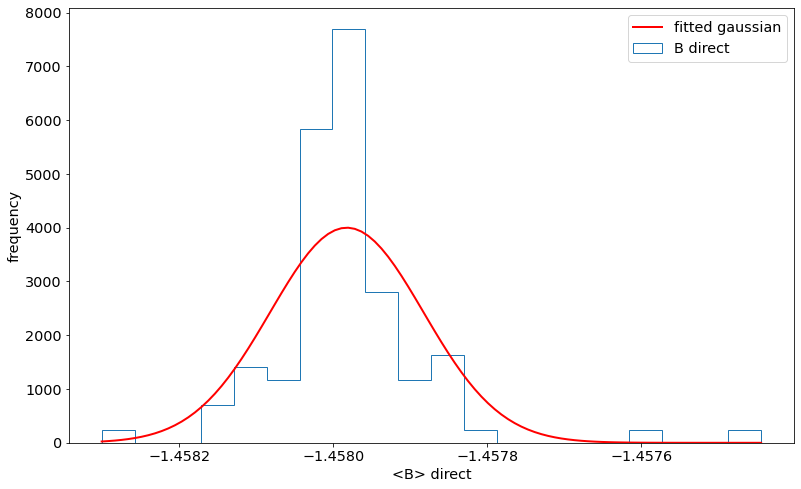

In [62]:
fig, ax = plt.subplots(1,1 , figsize=(13,8))
ax.hist(histogram,bins=20,histtype='step',density=True,label='B direct')
mu, std = norm.fit(histogram)
x = np.linspace(min(histogram), max(histogram), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, color='red', linewidth=2, label='fitted gaussian')
print('FIT PARAMETERS:\tmu =', mu, '\tsigma =', std)
ax.set_xlabel('<B> direct')
ax.set_ylabel('frequency')
ax.legend()

In [53]:
histogram_d = []
for i in range(100):
    histogram_d.append(g_val[i][1]) 

FIT PARAMETERS:	mu = 1.449389650579043e-05 	sigma = 0.0001344191478772095


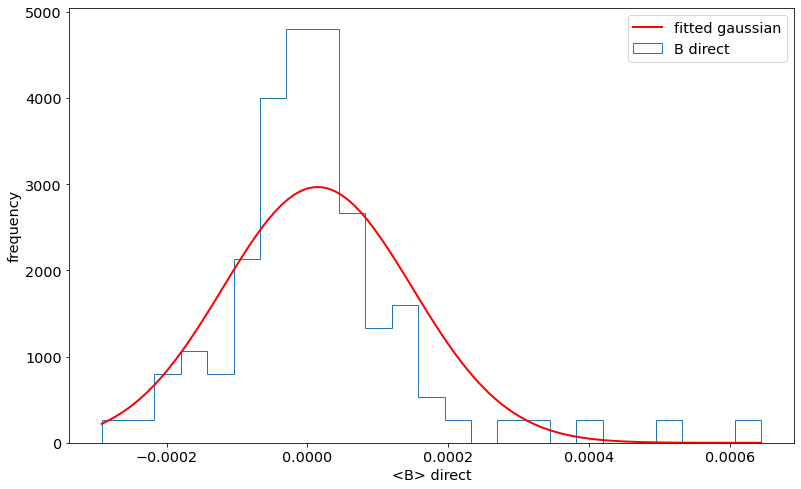

In [54]:
fig, ax = plt.subplots(1,1 , figsize=(13,8))
ax.hist(histogram_d,bins=25,histtype='step',density=True,label='B direct')
mu_d, std_d = norm.fit(histogram_d)
x_d = np.linspace(min(histogram_d), max(histogram_d), 100)
p_d = norm.pdf(x_d, mu_d, std_d)
ax.plot(x_d, p_d, color='red', linewidth=2, label='fitted gaussian')
print('FIT PARAMETERS:\tmu =', mu_d, '\tsigma =', std_d)
ax.set_xlabel('<B> direct')
ax.set_ylabel('frequency')
ax.legend()

In [16]:
s = np.random.normal(1.2260572351897472, 0.00031466841343484185, 1000)

In [15]:
s2 = np.random.normal(1.2259992009828542 , 0.0004070741983859207, 1000)

In [38]:
d = np.random.normal(4.914766018117936e-05 , 0.0001923376716945016, 1000)

FIT PARAMETERS:	mu = 1.2260612369414279 	sigma = 0.00031057010186980104


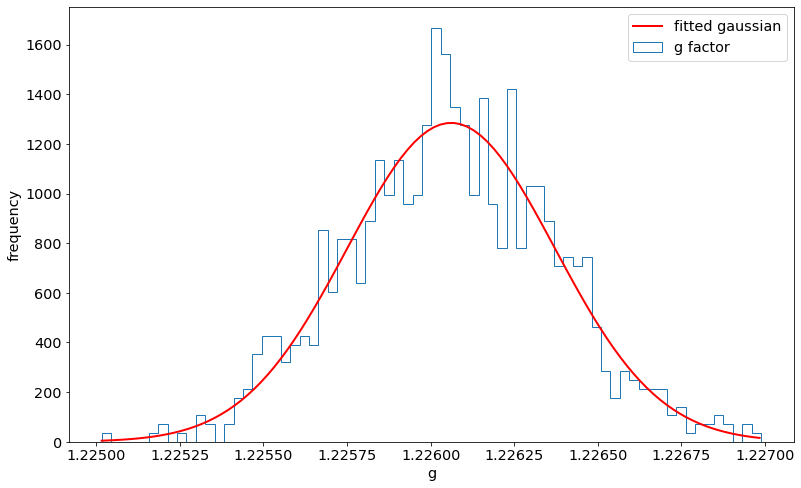

In [25]:
fig, ax = plt.subplots(1,1 , figsize=(13,8))
ax.hist(s,bins=70,histtype='step',density=True,label='g factor')
mu, std = norm.fit(s)
x = np.linspace(min(s), 2*1.226-min(s), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, color='red', linewidth=2, label='fitted gaussian')
print('FIT PARAMETERS:\tmu =', mu, '\tsigma =', std)
ax.set_xlabel('g')
ax.set_ylabel('frequency')
ax.legend()
fig.savefig('gaussian_g_not_d.svg', format='svg', dpi=1200)

FIT PARAMETERS:	mu = 1.2260147052527297 	sigma = 0.0003989965957014069


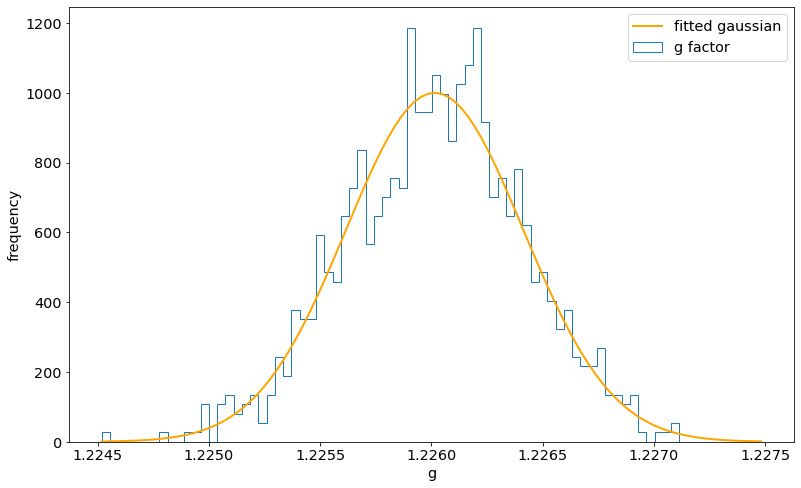

In [28]:
fig, ax = plt.subplots(1,1 , figsize=(13,8))
ax.hist(s2,bins=70,histtype='step',density=True,label='g factor')
mu, std = norm.fit(s2)
x = np.linspace(min(s2), 2*1.226-min(s2), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, color='orange', linewidth=2, label='fitted gaussian')
print('FIT PARAMETERS:\tmu =', mu, '\tsigma =', std)
ax.set_xlabel('g')
ax.set_ylabel('frequency')
ax.legend()
fig.savefig('gaussian_g_d.svg', format='svg', dpi=1200)

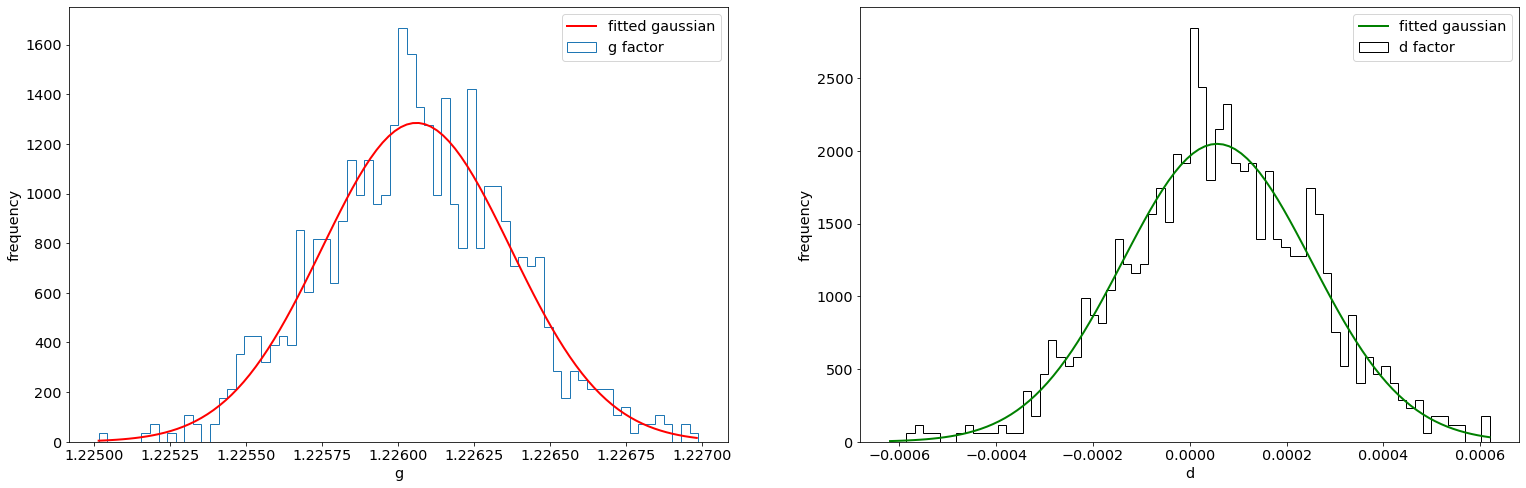

In [34]:
fig, (ax2,ax1) = plt.subplots(1,2 , figsize=(26,8))
ax2.hist(s,bins=70,histtype='step',density=True,label='g factor')
mu2, std2 = norm.fit(s)
x2 = np.linspace(min(s), 2*1.226-min(s), 100)
p2 = norm.pdf(x2, mu2, std2)
ax2.plot(x2, p2, color='red', linewidth=2, label='fitted gaussian')
ax2.set_xlabel('g')
ax2.set_ylabel('frequency')
ax2.legend()
ax1.hist(d,bins=70,histtype='step',density=True,label='d factor', color='black')
mu, std = norm.fit(d)
x = np.linspace(-max(d), max(d), 100)
p = norm.pdf(x, mu, std)
ax1.plot(x, p, color='green', linewidth=2, label='fitted gaussian')
ax1.set_xlabel('d')
ax1.set_ylabel('frequency')
ax1.legend()


fig.savefig('gaussian_d_and_g.svg',format='svg', dpi=1200)

In [39]:
x = d
fig, ax = plt.subplots() 
nbins = 55
n, bins, patches = ax.hist(x,nbins, density=True, facecolor = 'grey', alpha = 0.5, label='before'); 

centers = (0.5*(bins[1:]+bins[:-1]))
pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=[1.226,0.0001])

ax.plot(centers, norm.pdf(centers,*pars), 'k--',linewidth = 2, label='fit before') 
ax.set_title('$\mu={:}\pm{:}$, $\sigma={:}\pm{:}$'.format(pars[0],np.sqrt(cov[0,0]), pars[1], np.sqrt(cov[1,1 ])))

plt.show()

/opt/anaconda3/envs/my_root_env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ValueError: 
\mu=1.226\pminf
         ^
Unknown symbol: \pminf, found '\'  (at char 9), (line:1, col:10)

<Figure size 1080x360 with 1 Axes>

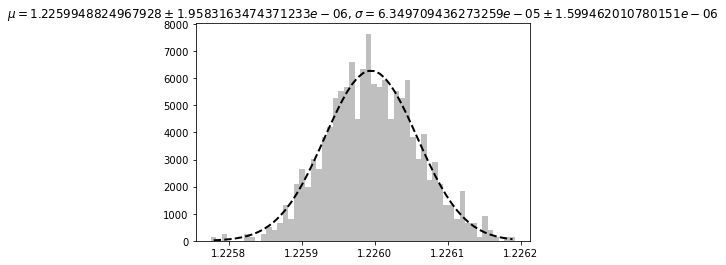

In [186]:
x = s
fig, ax = plt.subplots() 
nbins = 55
n, bins, patches = ax.hist(x,nbins, density=True, facecolor = 'grey', alpha = 0.5, label='before'); 

centers = (0.5*(bins[1:]+bins[:-1]))
pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=[1.226,0.0001])

ax.plot(centers, norm.pdf(centers,*pars), 'k--',linewidth = 2, label='fit before') 
ax.set_title('$\mu={:}\pm{:}$, $\sigma={:}\pm{:}$'.format(pars[0],np.sqrt(cov[0,0]), pars[1], np.sqrt(cov[1,1 ])))

plt.show()

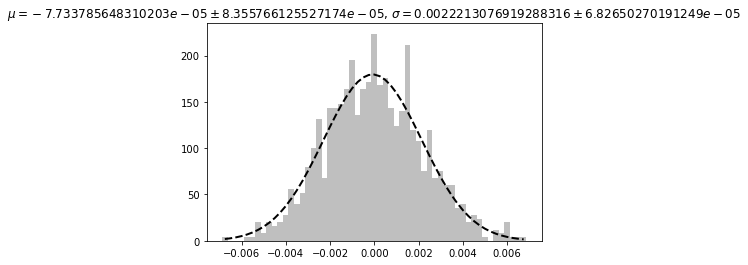

In [188]:
x = d
fig, ax = plt.subplots() 
nbins = 55
n, bins, patches = ax.hist(x,nbins, density=True, facecolor = 'grey', alpha = 0.5, label='before'); 

centers = (0.5*(bins[1:]+bins[:-1]))
pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=[0,0.0001])

ax.plot(centers, norm.pdf(centers,*pars), 'k--',linewidth = 2, label='fit before') 
ax.set_title('$\mu={:}\pm{:}$, $\sigma={:}\pm{:}$'.format(pars[0],np.sqrt(cov[0,0]), pars[1], np.sqrt(cov[1,1 ])))

plt.show()

In [ ]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def angle_unif():
    angles = []
    xi, yi, zi = sample_spherical(1, ndim=3)
    theta = np.arccos(zi[0])
    angles.append(theta)
    if math.atan2(yi,xi)<0:
        phi = math.atan2(yi,xi) + 2*np.pi
    else :
        phi = math.atan2(yi,xi)
    angles.append(phi)
    angles=np.array(angles)
    return angles

def accept_reject_decay():
    Omega = angle_unif()
    Omega1 = angle_unif()
    Omega2 = angle_unif()
    maxi = np.random.rand()*1.5
    X = (Omega[0],Omega[1],Omega1[0],Omega1[1], Omega2[0],Omega2[1])
    
    if maxi<=decay_distribution_precess(X,1.458):
        return Omega[0],Omega[1],Omega1[0],Omega1[1], Omega2[0],Omega2[1],decay_distribution_precess(X,1.458)
    else:
        while maxi>decay_distribution_precess(X,1.458):
            Omega = angle_unif()
            Omega1 = angle_unif()
            Omega2 = angle_unif()
            maxi = np.random.rand()*1.5
            X = (Omega[0],Omega[1],Omega1[0],Omega1[1], Omega2[0],Omega2[1])
    return Omega[0],Omega[1],Omega1[0],Omega1[1], Omega2[0],Omega2[1],decay_distribution_precess(X,1.458)        

In [189]:
X = np.loadtxt("angles/0.csv", dtype = float, delimiter = ",", unpack=True)

In [191]:
def regressLL(params):
    # Resave the initial parameter guesses
    #sx_precess = params[0]
    #sy_precess = params[0]
    #sz_precess = params[0]
    g0 = params

    # Calculate the predicted values from the initial parameter guesses
    yPred = 1
    for i in range(len(X[0])):
        angles = (X[0][i],X[1][i],X[2][i],X[3][i], X[4][i],X[5][i])
        #n2x = np.sin( X[i][4])*np.cos(X[i][5])
        #n2y = np.sin( X[i][4])*np.sin(X[i][5])
        #n2z = np.cos( X[i][4])
        yPred = yPred * decay_distribution_precess(angles,g0)
        #yPred.append(1-0.750*(sx_precess*n2x+sy_precess*n2y+sz_precess*n2z))

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.log(yPred)

    # Tell the function to return the NLL (this is what will be minimized)
    return(logLik)

In [ ]:
X,Y = np.loadtxt("g_L", dtype=float, delimiter=',', unpack=True)

In [ ]:
plt.plot(X,Y)

In [ ]:
i = 0
decay_distribution_precess((X[0][i],X[1][i],X[2][i],X[3][i],X[4][i],X[5][i]),1.458)

In [ ]:
N=20*10**5
M=1
minima = []
for j in range(M):
    X = []
    decay_dist=[]
    for i in range(N):
        a,b,c,d,e,f,g=accept_reject_decay() 
        X.append([a,b,c,d,e,f])
        decay_dist.append(g)
    #print("minimizing")    
    #res = minimize_scalar(regressLL, method='bounded', bounds=(1.448, 1.468))
    #minima.append(res.x)
    #print(str(j+1)+"%complete: min = " + str(res.x))

In [192]:
x_0 = np.linspace(1.308, 1.608, num=20)
y_0 = []
for i in range(20):
    print(i)
    y_0.append(regressLL(x_0[i]))

0


<ipython-input-191-0cae648bea1d>:15: RuntimeWarning: overflow encountered in double_scalars
  yPred = yPred * decay_distribution_precess(angles,g0)


KeyboardInterrupt: 

In [ ]:
plt.plot(x_0,y_0)

In [ ]:
x_1 = np.linspace(1.448, 1.488, num=20)
y_1 = []
for i in range(20):
    print(i)
    y_1.append(regressLL(x_1[i]))

In [ ]:
plt.plot(x_1,y_1)